## Imports

In [1]:
import torch
print(f'PyTorch CUDA is available? {torch.cuda.is_available()}')
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

PyTorch CUDA is available? True


## Reproducibility

In [2]:
def fix_random(seed: int) -> None:
    """Fix all the possible sources of randomness.

    Args:
        seed: the seed to use.
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

fix_random(42)

## Devices available

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Device: {device}")

Device: cuda


## Access Dataloader

In [4]:
from pathlib import Path
from PIL import Image
from torch import Tensor
from torch.utils.data import Dataset
from typing import List, Tuple

In [5]:
class GroceryStoreDataset(Dataset):

    def __init__(self, split: str, transform=None) -> None:
        super().__init__()

        self.root = Path("GroceryStoreDataset/dataset")
        self.split = split
        self.paths, self.labels = self.read_file()

        self.transform = transform

    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx) -> Tuple[Tensor, int]:
        img = Image.open(self.root / self.paths[idx])
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

    def read_file(self) -> Tuple[List[str], List[int]]:
        paths = []
        labels = []

        with open(self.root / f"{self.split}.txt") as f:
            for line in f:
                # path, fine-grained class, coarse-grained class
                path, _, label = line.replace("\n", "").split(", ")
                paths.append(path), labels.append(int(label))

        return paths, labels

    def get_num_classes(self) -> int:
        return max(self.labels) + 1

In [6]:
from torchvision import transforms as T, datasets

In [7]:
## Rimettere a 260x260

tsfms_std = T.Compose([
    T.Resize(size=(224, 224)),
    T.ToTensor(),
    # T.Lambda(lambda x: x.flatten()),
])

tsfms_increasing = T.Compose([
    T.RandomHorizontalFlip(),
    T.RandomResizedCrop(size=(150, 150), scale=(0.7, 0.9)),
    T.ToTensor(),
    T.Resize(size=(224, 224)),
    # T.Lambda(lambda x: x.flatten()),
])

train_dset = GroceryStoreDataset(
    split="train",
    transform=tsfms_std,
)
increased_train_dst = GroceryStoreDataset(
    split="train",
    transform=tsfms_increasing,
)
val_dset = GroceryStoreDataset(
    split="val",
    transform=tsfms_std,
)
test_dset = GroceryStoreDataset(
    split="test",
    transform=tsfms_std,
)
n_classes = 43
input_dim = len(train_dset[0][0])

increased_dataset = torch.utils.data.ConcatDataset([increased_train_dst,train_dset])
print(len(increased_dataset))

5280


In [8]:
from torch.utils.data import DataLoader

In [9]:
print(len(train_dset))
print(len(val_dset))

2640
296


In [10]:
batch_size = 64

train_dl = DataLoader(
    train_dset,
    batch_size=batch_size,
    shuffle=True
)
val_dl = DataLoader(
    val_dset,
    batch_size=batch_size
)
test_dl = DataLoader(
    test_dset,
    batch_size=batch_size
)

## ResNet Model

In [11]:
from torchvision.models import resnet18, ResNet18_Weights

In [27]:
class Resnet18(torch.nn.Module):
    def __init__(self, n_classes, weights):
        super().__init__()
        self.base_model = resnet18(weights=weights)
        self.base_model.fc = torch.nn.Linear(self.base_model.fc.in_features, n_classes)
    
    def set_requires_grad(self, layer, train):
        for p in layer.parameters():
            p.requires_grad = train
    
    def forward(self, x):
        x = self.base_model(x)
        return x


In [28]:
resnet_model = Resnet18(
    n_classes=n_classes,
    weights=ResNet18_Weights.IMAGENET1K_V1
)

In [29]:
pushed_net = resnet_model.to(device)

In [30]:
## Freeze base model layer (not fc)
for layer in [pushed_net.base_model.conv1, pushed_net.base_model.bn1, pushed_net.base_model.layer1, pushed_net.base_model.layer2, pushed_net.base_model.layer3, pushed_net.base_model.layer4]:
    pushed_net.set_requires_grad(layer, train=False)

### Compile network

In [22]:
from torch.optim import Adam, AdamW
from torch.optim.lr_scheduler import OneCycleLR, ReduceLROnPlateau

In [31]:
initial_lr = 1e-3
optimizer = AdamW(pushed_net.parameters(), lr=initial_lr, weight_decay=1e-4)
num_epochs = 30
num_steps = num_epochs * len(train_dl)
# lr_scheduler = OneCycleLR(optimizer, initial_lr, total_steps=num_steps)
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.6, patience=2, min_lr=1e-5)

## Train network

In [24]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [32]:
def ncorrect(scores, y):
    y_hat = torch.argmax(scores, -1)
    return (y_hat == y).sum()

def accuracy(scores, y):
    correct = ncorrect(scores, y)
    return correct.true_divide(y.shape[0])

def train_loop(model, train_dl, batch_size, constant_lr, epochs, opt, scheduler, val_dl=None, verbose=False):
    best_val_acc = 0
    best_params = []
    best_epoch = -1

    train_losses = []
    train_accs = []

    val_losses = []
    val_accs = []

    for e in tqdm(range(epochs)):
    # for e in range(epochs):
        model.train()
        # Train
        train_loss = 0
        train_samples = 0
        train_acc = 0
        # running_loss = 0
        # correct = 0
        # total = 0

        ## Get last learning rate
        if scheduler != None:
            lr = scheduler.get_last_lr()
        else:
            lr = constant_lr

        for i, train_data in enumerate(train_dl):
            imgs = train_data[0].to(device)
            labels = train_data[1].to(device)

            opt.zero_grad()  # clear

            scores = model(imgs)
            loss = F.cross_entropy(scores, labels)

            loss.backward()  # fill
            opt.step()       # Weight Optimizer step
            # scheduler.step() # Learning Rate Scheduler step

            train_loss += loss.item() * imgs.shape[0]
            train_samples += imgs.shape[0]
            train_acc += ncorrect(scores, labels).item()

            train_losses.append(train_loss/train_samples)
            train_accs.append(train_acc/train_samples)

            ## Write in tensorboard
            # if i % batch_size == batch_size-1:
                # train_losses.append(train_loss/batch_size)
                # train_accs.append(train_acc/batch_size)
                # if writer != None:
                #     writer.add_scalar("Loss/train", train_loss/batch_size, e)
                #     writer.add_scalar("Accuracy/train", train_acc/batch_size, e)

            
        # train_loss = running_loss / len(train_dl)
        # train_acc = 100 * correct / total
        train_acc /= train_samples
        train_loss /= train_samples

        # Validation
        model.eval()
        with torch.no_grad():
            val_loss = 0
            val_samples = 0
            val_acc = 0
            # correct = 0
            # total = 0
            if val_dl is not None:
                for i, val_data in enumerate(val_dl):
                    imgs = val_data[0].to(device)
                    labels = val_data[1].to(device)
                    val_scores = model(imgs)
                    val_loss += F.cross_entropy(val_scores, labels).item() * imgs.shape[0]

                    val_samples += imgs.shape[0]
                    val_acc += ncorrect(val_scores, labels).item()

                    val_losses.append(val_loss/val_samples)
                    val_accs.append(val_acc/val_samples)

                    # if i % batch_size == batch_size-1:
                        # val_losses.append(val_loss/batch_size)
                        # val_accs.append(val_acc/batch_size)
                        # if writer != None:
                        #     writer.add_scalar("Loss/val", val_loss/batch_size, e)
                        #     writer.add_scalar("Accuracy/val", val_acc/batch_size, e)

                    # val_scores = model(imgs)
                    # _, predicted = torch.max(val_scores.data, 1)
                    # total += labels.size(0)
                    # correct += (predicted == labels).sum().item()

                val_acc /= val_samples
                val_loss /= val_samples
                # val_acc = 100 * correct / total

            if val_dl is None or val_acc > best_val_acc:
                best_val_acc = val_acc if val_dl is not None else 0
                best_params = model.state_dict()
                torch.save(best_params, "best_model2.pth")
                best_epoch = e
        
        #### Learning Rate Scheduler step
        ## if scheduler == ReduceLROnPlateau
        if isinstance(scheduler,ReduceLROnPlateau):
            scheduler.step(val_loss)
            # scheduler.step(val_acc)
        elif isinstance(scheduler,OneCycleLR):
            scheduler.step()

        # if verbose and e % 5 == 0:
        if verbose:
            print(f"Epoch {e}: lr {lr} - train loss {train_loss:.3f} - train acc {train_acc:.3f}" + ("" if val_dl is None else f" - valid loss {val_loss:.3f} - valid acc {val_acc:.3f}"))
            # print(f"Epoch {e}: train loss {train_loss:.3f} - train acc {train_acc:.3f}" + ("" if val_dl is None else f" - valid loss - valid acc {val_acc:.3f}"))

    if verbose and val_dl is not None:
        print(f"Best epoch {best_epoch}, best acc {best_val_acc}")

    return best_val_acc, best_params, best_epoch, (train_losses, train_accs, val_losses, val_accs)

In [33]:
best_val_acc, best_params, best_epoch, tracks = train_loop(
    pushed_net,
    train_dl,
    batch_size,
    1e-3,
    num_epochs,
    optimizer,
    lr_scheduler,
    val_dl,
    verbose=True
)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 0: lr [0.001] - train loss 2.676 - train acc 0.343 - valid loss 2.212 - valid acc 0.436
Epoch 1: lr [0.001] - train loss 1.457 - train acc 0.664 - valid loss 1.641 - valid acc 0.598
Epoch 2: lr [0.001] - train loss 0.948 - train acc 0.818 - valid loss 1.350 - valid acc 0.679
Epoch 3: lr [0.001] - train loss 0.688 - train acc 0.884 - valid loss 1.211 - valid acc 0.703
Epoch 4: lr [0.001] - train loss 0.518 - train acc 0.933 - valid loss 1.151 - valid acc 0.669
Epoch 5: lr [0.001] - train loss 0.425 - train acc 0.950 - valid loss 1.056 - valid acc 0.703
Epoch 6: lr [0.001] - train loss 0.362 - train acc 0.955 - valid loss 1.030 - valid acc 0.730
Epoch 7: lr [0.001] - train loss 0.306 - train acc 0.968 - valid loss 1.008 - valid acc 0.720
Epoch 8: lr [0.001] - train loss 0.261 - train acc 0.971 - valid loss 0.974 - valid acc 0.740
Epoch 9: lr [0.001] - train loss 0.231 - train acc 0.983 - valid loss 0.937 - valid acc 0.720
Epoch 10: lr [0.001] - train loss 0.202 - train acc 0.982 - 

In [34]:
torch.cuda.empty_cache()

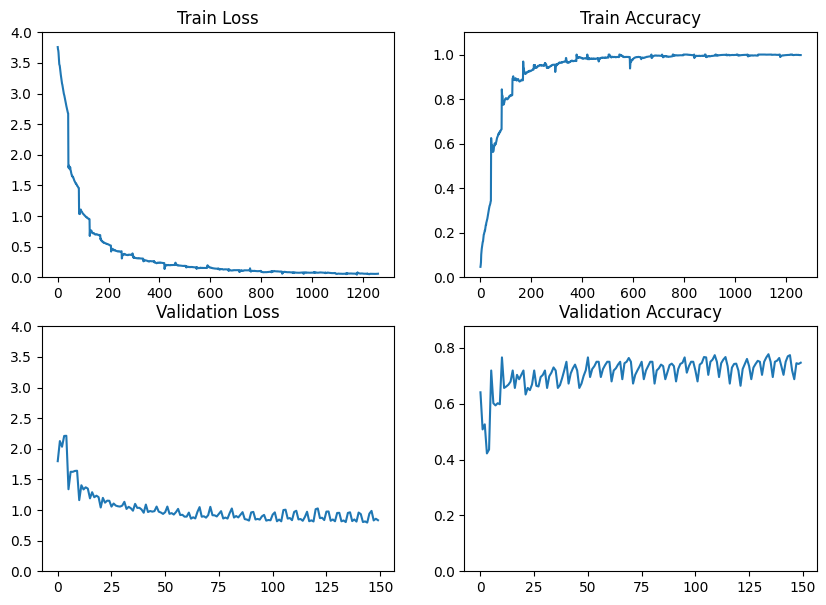

In [35]:
labels = ['Train Loss', 'Train Accuracy', 'Validation Loss', 'Validation Accuracy']

plt.figure(figsize=(10, 7))

for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.plot(range(len(tracks[i])), tracks[i])
    # plt.yscale('log')
    if i%2==1:
        plt.ylim(0, max(tracks[i]) + 0.1)
    else:
        plt.ylim(0, 4)
    plt.title(labels[i])
plt.show()

In [36]:
## Unfreeze base model layer (not fc)
for layer in [pushed_net.base_model.conv1, pushed_net.base_model.bn1, pushed_net.base_model.layer1, pushed_net.base_model.layer2, pushed_net.base_model.layer3, pushed_net.base_model.layer4]:
    pushed_net.set_requires_grad(layer, train=True)

In [37]:
initial_lr = 1e-5
optimizer = AdamW(pushed_net.parameters(), lr=initial_lr, weight_decay=1e-5)
num_epochs = 30
num_steps = num_epochs * len(train_dl)
# lr_scheduler = OneCycleLR(optimizer, initial_lr, total_steps=num_steps)
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.6, patience=2, min_lr=1e-6)

In [38]:
best_val_acc, best_params, best_epoch, fine_tune_tracks = train_loop(
    pushed_net,
    train_dl,
    batch_size,
    1e-6,
    num_epochs,
    optimizer,
    lr_scheduler,
    val_dl,
    verbose=True
)

  0%|          | 0/30 [00:00<?, ?it/s]

/home/rda1027/miniconda3/envs/ai/lib/python3.11/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712608853085/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 0: lr [1e-05] - train loss 0.042 - train acc 0.999 - valid loss 0.781 - valid acc 0.784
Epoch 1: lr [1e-05] - train loss 0.019 - train acc 1.000 - valid loss 0.735 - valid acc 0.791
Epoch 2: lr [1e-05] - train loss 0.013 - train acc 1.000 - valid loss 0.740 - valid acc 0.797
Epoch 3: lr [1e-05] - train loss 0.009 - train acc 1.000 - valid loss 0.702 - valid acc 0.807
Epoch 4: lr [1e-05] - train loss 0.008 - train acc 1.000 - valid loss 0.701 - valid acc 0.804
Epoch 5: lr [1e-05] - train loss 0.006 - train acc 1.000 - valid loss 0.675 - valid acc 0.807
Epoch 6: lr [1e-05] - train loss 0.006 - train acc 1.000 - valid loss 0.663 - valid acc 0.814
Epoch 7: lr [1e-05] - train loss 0.004 - train acc 1.000 - valid loss 0.654 - valid acc 0.818
Epoch 8: lr [1e-05] - train loss 0.004 - train acc 1.000 - valid loss 0.642 - valid acc 0.821
Epoch 9: lr [1e-05] - train loss 0.003 - train acc 1.000 - valid loss 0.646 - valid acc 0.811
Epoch 10: lr [1e-05] - train loss 0.003 - train acc 1.000 - 

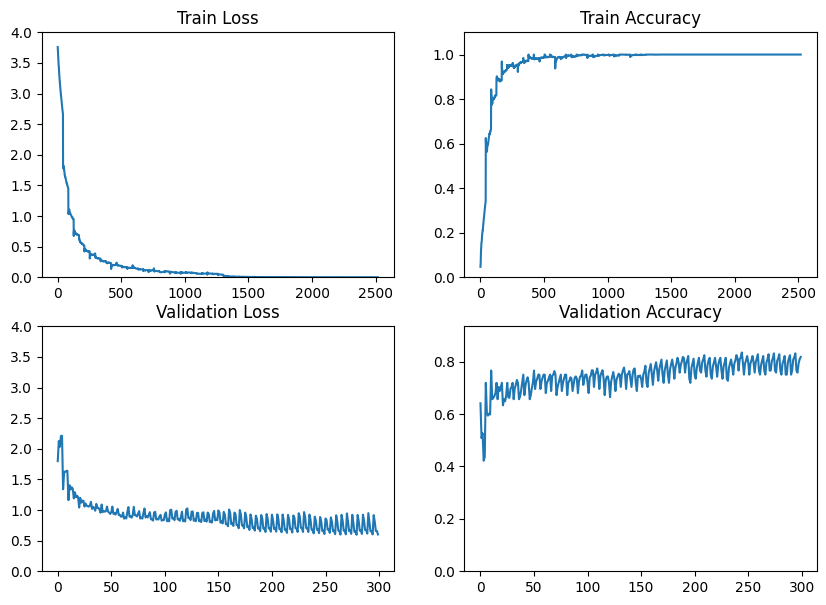

In [41]:
labels = ['Train Loss', 'Train Accuracy', 'Validation Loss', 'Validation Accuracy']

plt.figure(figsize=(10, 7))

for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.plot(range(len(tracks[i]) + len(fine_tune_tracks[i])), tracks[i] + fine_tune_tracks[i])
    # plt.yscale('log')
    if i%2==1:
        plt.ylim(0, max(fine_tune_tracks[i]) + 0.1)
    else:
        plt.ylim(0, 4)
    plt.title(labels[i])
plt.show()